# EECS 4422 Assignment 2

## Import Libraries

In [1021]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import cv2
import torch
import torch.nn as nn
import os
import kornia
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
#rcParams['figure.figsize'] = 11,8
plt.gray()

<Figure size 432x288 with 0 Axes>

## Functions

In [1022]:
#Displays Tensors as image
def imshowTorch(input):
    # (height, width) = input.shape[2],input.shape[3]
    # image = input.numpy()
    # image = np.reshape(image, (height, width))
    image = kornia.tensor_to_image(input)
    plt.imshow(image)

In [1023]:
#Converts numpy arrays to Kornia compatable tensors
def toKornia(img):
    print(img.shape)
    img = kornia.image_to_tensor(img) #Kornia in shape BCHW
    print(img.shape)
    #Adding in dummy axis from: https://sparrow.dev/adding-a-dimension-to-a-tensor-in-pytorch/
    img = torch.unsqueeze(img, dim=0)
    print(img.shape)
    return img

In [1024]:
#Converts images to grayscale
def img2grayscale(img):
    img = img.astype(np.float32)/255
    img = (img[:,:,0]+ img[:,:,1]+ img[:,:,2]) / 3

    return img

In [1025]:
#Q1.1
def MyCanny(img, sigma, tau):
    
    #GaussianBlur2D from https://kornia.readthedocs.io/en/latest/filters.html
    gauss = kornia.filters.GaussianBlur2d((3, 3), (sigma, sigma))

    img_blur = gauss(img)

    #Spatial Gradient2D from https://kornia.readthedocs.io/en/latest/filters.html
    #By default 1st order derivative and 'diff' derivative modality
    gradient = kornia.filters.spatial_gradient(img_blur)

    #Find magnitude and 1st order derivatives https://kornia-tutorials.readthedocs.io/en/latest/filtering_edges.html
    #   and edges-pff document given in A2 document: https://drive.google.com/file/d/0Bz1dfcnrpXM-QVpHZ1p6SUxoaXM/view?resourcekey=0-aYFhFiQTvM4x5CbfN5gllg
    grad_x = gradient[:,:,0]
    grad_y = gradient[:,:,1]
    img_grad_mag = torch.sqrt(torch.square(grad_x) + torch.square(grad_y)) #From lecture 6 (edge detection)

    fig, ax = plt.subplots(1,3, figsize=(30,30))
    ax[0].imshow(kornia.tensor_to_image((1. - grad_x.clamp(0.,1.))))
    ax[1].imshow(kornia.tensor_to_image((1. - grad_y.clamp(0.,1.))))

    #Threshold grad magnitude above given tau
    img_grad_mag = img_grad_mag / img_grad_mag.max() * 255
    img_grad_mag = img_grad_mag > tau
    ax[2].imshow(kornia.tensor_to_image(img_grad_mag))

    return 0

    

In [1026]:
def findEnergy(img, showimg=True):

    #Spatial Gradient2D from https://kornia.readthedocs.io/en/latest/filters.html
    # Using 'sobel' 
    # output = kornia.filters.sobel(img)
    # imshowTorch(output)
    
    gradient = kornia.filters.spatial_gradient(img)
    grad_x = gradient[:,:,0]
    grad_y = gradient[:,:,1]
    img_grad_mag = torch.sqrt(torch.square(grad_x) + torch.square(grad_y)) #From lecture 6 (edge detection)

    
    if showimg == True:
        fig, ax = plt.subplots(1,3, figsize=(30,30))
        ax[0].imshow(kornia.tensor_to_image((1. - grad_x.clamp(0.,1.))))
        ax[1].imshow(kornia.tensor_to_image((1. - grad_y.clamp(0.,1.))))
        ax[2].imshow(kornia.tensor_to_image(img_grad_mag))

    return img_grad_mag

In [1027]:
def findMin(m, i, j):
    result, index = (0,0)
    #topLeft, topMiddle, topRight = 100000000
    topLeft = [10000000,i-1,j-1]
    topMiddle = [1000000, i-1, j]
    topRight = [10000000, i-1,j+1]

    # if i == 0:
    #     result = m[i,j]
    # elif j == 0:
    #     topMiddle = m[i-1,j]
    #     topRight = m[i-1,j+1]
    # elif j == (m.shape[1] - 1):
    #     topLeft = m[i-1,j-1] 
    #     topMiddle = m[i-1,j]
    # else:
    #     topLeft = m[i-1,j-1]
    #     topMiddle = m[i-1,j]
    #     topRight = m[i-1,j+1]

    if i == 0:
        result = m[i,j]
    elif j == 0:
        topMiddle[0] = m[topMiddle[1],topMiddle[2]]
        topRight[0] = m[topRight[1],topRight[2]]
    elif j == (m.shape[1] - 1):
        topLeft[0] = m[topLeft[1],topLeft[2]] 
        topMiddle[0] = m[topMiddle[1],topMiddle[2]]
    else:
        topLeft[0] = m[topLeft[1],topLeft[2]] 
        topMiddle[0] = m[topMiddle[1],topMiddle[2]]
        topRight[0] = m[topRight[1],topRight[2]]
    
    output = min([topLeft, topMiddle, topRight], key = lambda t: t[0])

    
    result = output[0]
    index = output[2]   
    #print(topLeft, topMiddle, topRight, result, index)
    return result, index

In [1028]:
def findPath(img, m):

    #(h, w) = m.shape[2:]
    york_k = toKornia(img)
    M = findEnergy(york_k, showimg=False)
    m = kornia.tensor_to_image(M)
    m = m.sum(axis=2)

    
    (h,w) = img.shape[:2]
    result, index = (0,0)
    seam = np.zeros_like(m)

    for i in range(1, h):
        for j in range(0, w):
            min, seam[i,j] = findMin(m,i,j)
            m[i,j] += min
            
    return seam, m

In [1029]:
def resize(img, m):
    (h,w) = img.shape[:2]
    seam, m = findPath(img,m)

    mask = np.ones((h,w), dtype=bool)
    j = np.argmin(m[-1])

    for i in reversed(range(h)):
        mask[i, j] = False
        j = int(seam[i, j])
        # mask[i, j-1] = False
        # j = int(seam[i, j-1])

    mask = np.stack([mask] * 3, axis=2)
    img = img[mask].reshape((h, w - 1, 3))

    return img, m

    

### Question 1

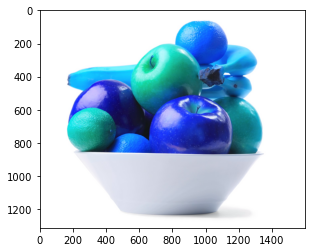

In [1030]:
#Read in fruit img
fruit = cv2.imread('bowl-of-fruit.jpg')
plt.imshow(fruit)

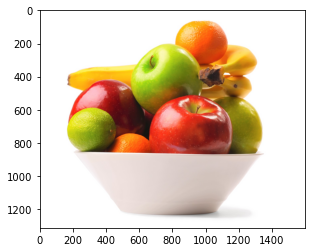

In [1031]:
#Convert to rgb
fruit = cv2.cvtColor(fruit, cv2.COLOR_BGR2RGB)
plt.imshow(fruit)

In [1032]:
#Convert to Grayscale
#fruit_gr = fruit.astype(np.float32)/255
#fruit_gr = (fruit_gr[:,:,0]+ fruit_gr[:,:,1]+ fruit_gr[:,:,2]) / 3
#fruit_gr = cv2.cvtColor(fruit, cv2.COLOR_RGB2GRAY)
fruit_gr = img2grayscale(fruit)

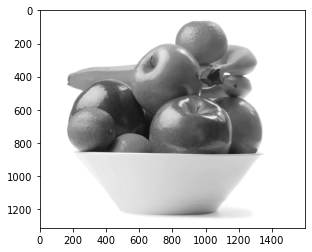

In [1033]:
#Greyscale img result
plt.imshow(fruit_gr)

In [1034]:
#fruit_k: torch.tensor = kornia.image_to_tensor(fruit_gr)
#fruit_k = kornia.image_to_tensor(fruit_gr) #Kornia in shape BCHW

In [1035]:
#fruit_k.shape

In [1036]:
#Adding in dummy axis from: https://sparrow.dev/adding-a-dimension-to-a-tensor-in-pytorch/
#fruit_k = torch.unsqueeze(fruit_k, dim=0)

In [1037]:
#fruit_k.shape

In [1038]:
#Conversion to torch tensor for kornia
fruit_k = toKornia(fruit_gr)

(1312, 1600)
torch.Size([1, 1312, 1600])
torch.Size([1, 1, 1312, 1600])


In [1039]:
type(fruit_k)

torch.Tensor

In [1040]:
#foo = kornia.tensor_to_image(fruit_k)

In [1041]:
#foo.shape

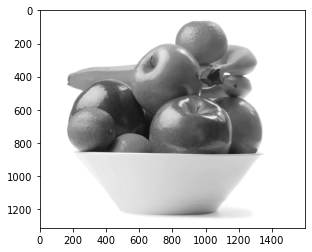

In [1042]:
#Show image as torch tensor
imshowTorch(fruit_k)

0

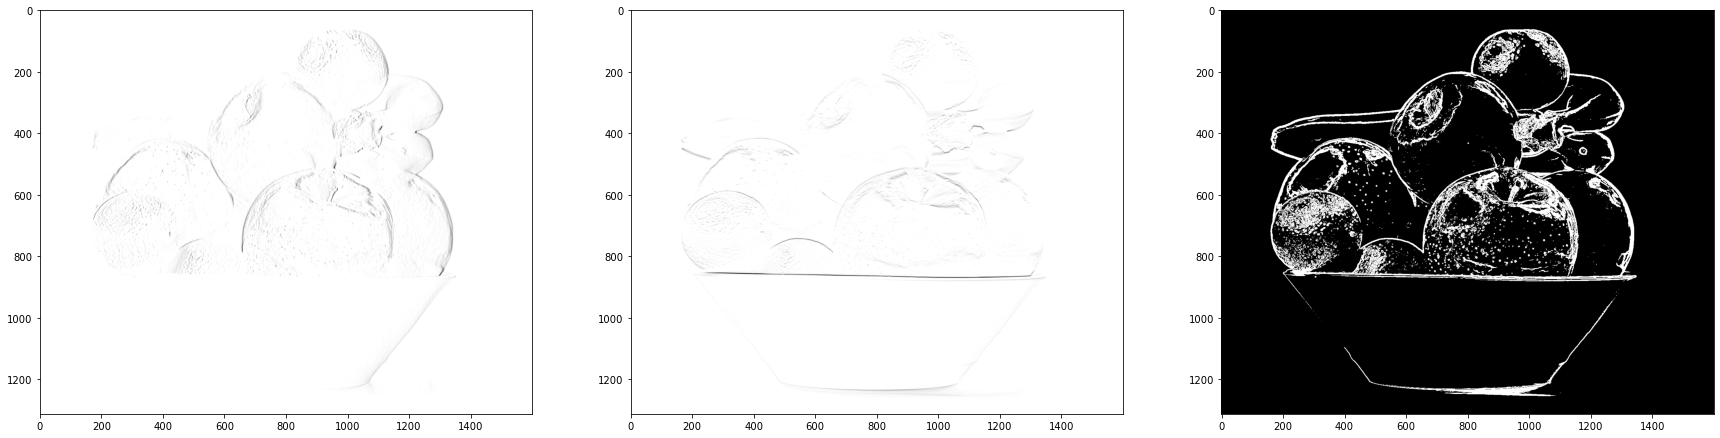

In [1043]:
#Display (from left to right) x grad, y grad, and the resultant edge detection
MyCanny(fruit_k, 1.5, 11)

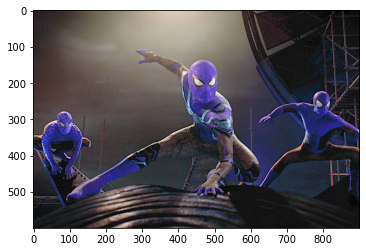

In [1044]:
#Read in spiderman image
spidey = cv2.imread('Spider-Man-No-Way-Home-triple-threat.jpg')
plt.imshow(spidey)

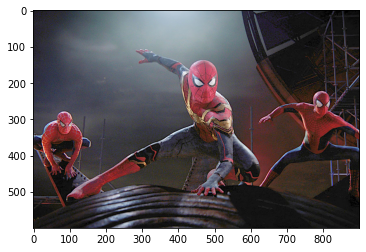

In [1045]:
#Conversion to RGB 
spidey = cv2.cvtColor(spidey, cv2.COLOR_BGR2RGB)
plt.imshow(spidey)

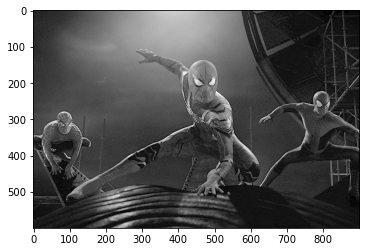

In [1046]:
#Greyscale
spidey_gr = img2grayscale(spidey)
plt.imshow(spidey_gr)

In [1047]:
#Convert to torch tensor
spidey_k = toKornia(spidey_gr)

(600, 900)
torch.Size([1, 600, 900])
torch.Size([1, 1, 600, 900])


In [1048]:
type(spidey_k)

torch.Tensor

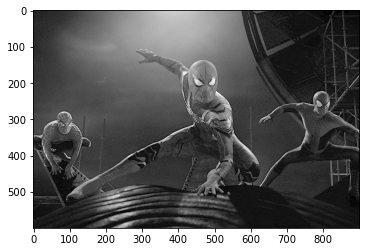

In [1049]:
imshowTorch(spidey_k)

0

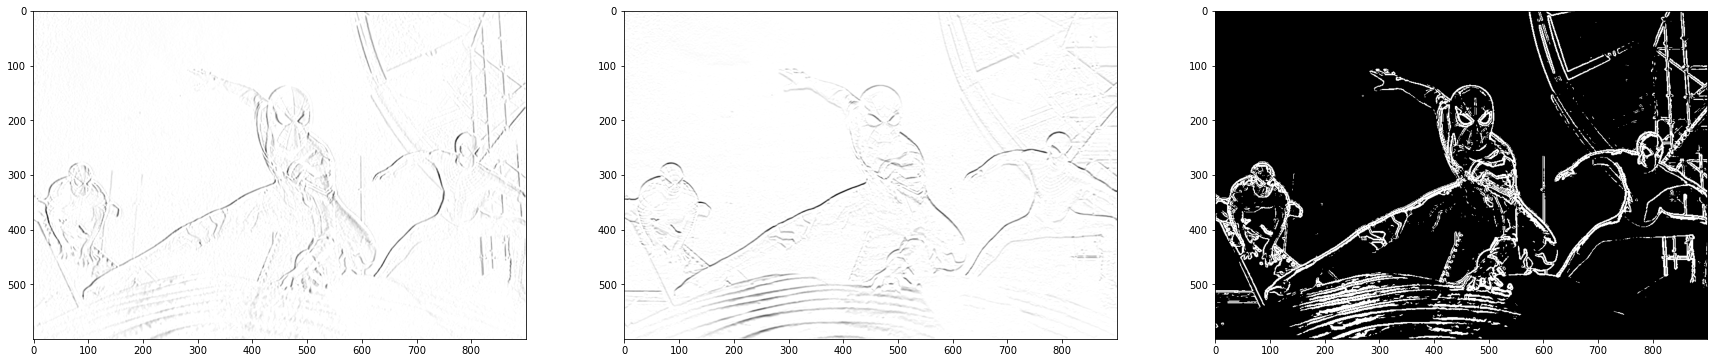

In [1050]:
#Display (left to right) x grad, y grad, Canny edge detector output
MyCanny(spidey_k, 1.5, 30)

### Question 2

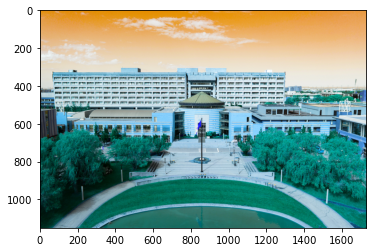

In [1051]:
york = cv2.imread('York.jpg')
plt.imshow(york)

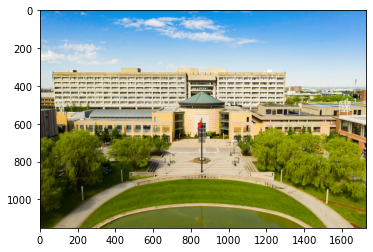

In [1052]:
york = cv2.cvtColor(york, cv2.COLOR_BGR2RGB)
plt.imshow(york)

(1151, 1728, 3)
torch.Size([3, 1151, 1728])
torch.Size([1, 3, 1151, 1728])


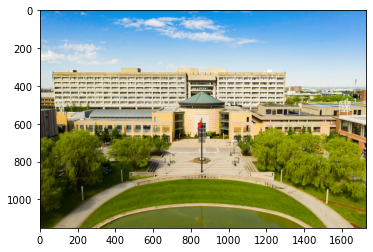

In [1053]:
#york_gr = img2grayscale(york)
#plt.imshow(york_gr)
york = york.astype(np.float32)/255
#york = (york[:,:,0]+ york[:,:,1]+ york[:,:,2]) / 1
#york = (york[:,:,0]+ york[:,:,1]+ york[:,:,2]) * 3
york_k = toKornia(york)
imshowTorch(york_k)

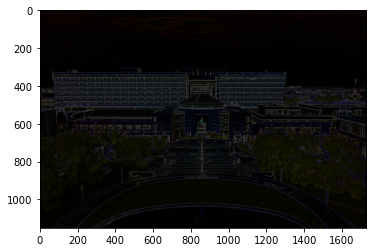

In [1054]:
imshowTorch(kornia.filters.sobel(york_k)) #Verify expected output

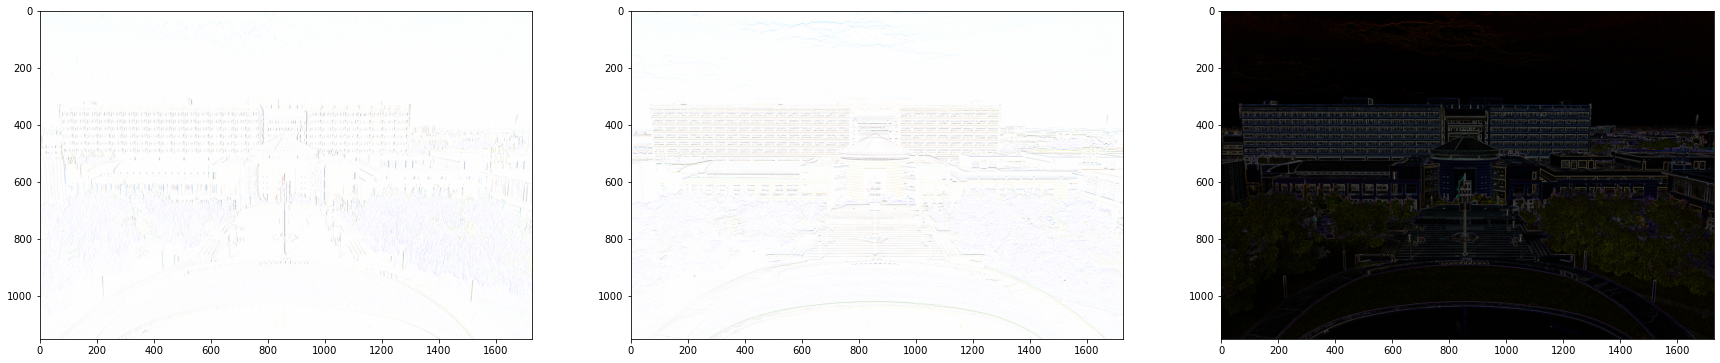

In [1055]:
M = findEnergy(york_k) #Our output
#a,b,c

In [1056]:
M.shape

torch.Size([1, 3, 1151, 1728])

In [1057]:
m = kornia.tensor_to_image(M)

In [1058]:
m.shape

(1151, 1728, 3)

In [1059]:
m = m.sum(axis=2)
#M = torch.sum(M, dim=3)

In [1060]:
m[1,3]

0.025660163

In [1061]:
m.shape[:2]

(1151, 1728)

In [1062]:
#m.shape[0]

In [1063]:
data = [ (1, 7.57,3), (2, 2.1,4), (3, 1.2,5), (4, 2.1,6), (5, 0.01,7), 
         (6, 0.5,8), (7, 0.2,0), (8, 0.6,10)]

In [1064]:
output = min(data, key = lambda t: t[2])
print(output)

(7, 0.2, 0)


In [1065]:
output[1:]

(0.2, 0)

In [1066]:
(h,w) = m.shape[:2]
print(h,w)

1151 1728


In [1067]:
newWidth = 1200
newHeight = 1151


In [1068]:
york_adjusted = york.copy()
for i in range(w - newWidth):
    york_adjusted, m = resize(york_adjusted,m)
plt.imshow(york_adjusted)


(1151, 1728, 3)
torch.Size([3, 1151, 1728])
torch.Size([1, 3, 1151, 1728])
(1151, 1727, 3)
torch.Size([3, 1151, 1727])
torch.Size([1, 3, 1151, 1727])


KeyboardInterrupt: 

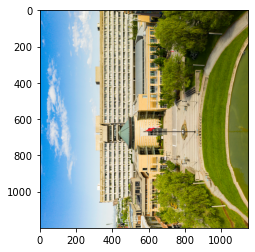

In [ ]:
#york_adjusted = cv2.rotate(york_adjusted, cv2.ROTATE_90_CLOCKWISE)
york_adjusted = cv2.transpose(york_adjusted)
plt.imshow(york_adjusted)

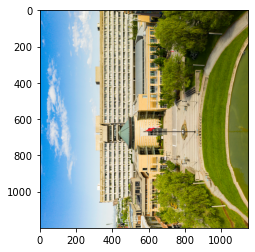

In [ ]:
for i in range(h - newHeight):
    york_adjusted, m = resize(york_adjusted, m)
plt.imshow(york_adjusted)

In [ ]:
newWidth = 1728
newHeight = 720

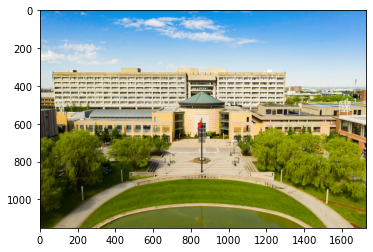

In [ ]:
york_adjusted = york.copy()
for i in range(w - newWidth):
    york_adjusted, m = resize(york_adjusted,m)
plt.imshow(york_adjusted)

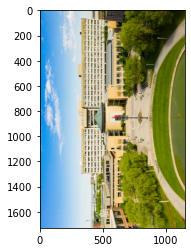

In [ ]:
#york_adjusted = cv2.rotate(york_adjusted, cv2.ROTATE_90_CLOCKWISE)
york_adjusted = cv2.transpose(york_adjusted)
plt.imshow(york_adjusted)

(1728, 1151, 3)
torch.Size([3, 1728, 1151])
torch.Size([1, 3, 1728, 1151])
(1728, 1150, 3)
torch.Size([3, 1728, 1150])
torch.Size([1, 3, 1728, 1150])
(1728, 1149, 3)
torch.Size([3, 1728, 1149])
torch.Size([1, 3, 1728, 1149])
(1728, 1148, 3)
torch.Size([3, 1728, 1148])
torch.Size([1, 3, 1728, 1148])
(1728, 1147, 3)
torch.Size([3, 1728, 1147])
torch.Size([1, 3, 1728, 1147])
(1728, 1146, 3)
torch.Size([3, 1728, 1146])
torch.Size([1, 3, 1728, 1146])
(1728, 1145, 3)
torch.Size([3, 1728, 1145])
torch.Size([1, 3, 1728, 1145])
(1728, 1144, 3)
torch.Size([3, 1728, 1144])
torch.Size([1, 3, 1728, 1144])
(1728, 1143, 3)
torch.Size([3, 1728, 1143])
torch.Size([1, 3, 1728, 1143])
(1728, 1142, 3)
torch.Size([3, 1728, 1142])
torch.Size([1, 3, 1728, 1142])
(1728, 1141, 3)
torch.Size([3, 1728, 1141])
torch.Size([1, 3, 1728, 1141])
(1728, 1140, 3)
torch.Size([3, 1728, 1140])
torch.Size([1, 3, 1728, 1140])
(1728, 1139, 3)
torch.Size([3, 1728, 1139])
torch.Size([1, 3, 1728, 1139])
(1728, 1138, 3)
torch.Siz

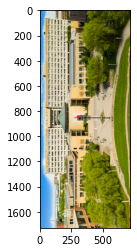

In [ ]:
for i in range(h - newHeight):
    york_adjusted, m = resize(york_adjusted, m)
plt.imshow(york_adjusted)

In [1069]:
spidey.shape

(600, 900, 3)

In [1070]:
(h,w) = spidey.shape[:2]
print(h,w)

600 900


In [1071]:
newWidth = 850
newHeight = 400

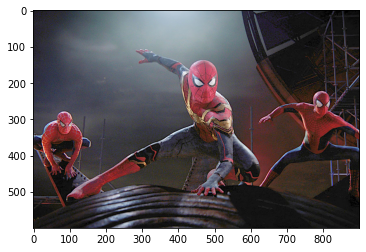

In [1072]:
spidey = spidey.astype(np.float32)/255
spidey_adjusted = spidey.copy()
plt.imshow(spidey_adjusted)

(600, 900, 3)
torch.Size([3, 600, 900])
torch.Size([1, 3, 600, 900])
(600, 899, 3)
torch.Size([3, 600, 899])
torch.Size([1, 3, 600, 899])
(600, 898, 3)
torch.Size([3, 600, 898])
torch.Size([1, 3, 600, 898])
(600, 897, 3)
torch.Size([3, 600, 897])
torch.Size([1, 3, 600, 897])
(600, 896, 3)
torch.Size([3, 600, 896])
torch.Size([1, 3, 600, 896])
(600, 895, 3)
torch.Size([3, 600, 895])
torch.Size([1, 3, 600, 895])
(600, 894, 3)
torch.Size([3, 600, 894])
torch.Size([1, 3, 600, 894])
(600, 893, 3)
torch.Size([3, 600, 893])
torch.Size([1, 3, 600, 893])
(600, 892, 3)
torch.Size([3, 600, 892])
torch.Size([1, 3, 600, 892])
(600, 891, 3)
torch.Size([3, 600, 891])
torch.Size([1, 3, 600, 891])
(600, 890, 3)
torch.Size([3, 600, 890])
torch.Size([1, 3, 600, 890])
(600, 889, 3)
torch.Size([3, 600, 889])
torch.Size([1, 3, 600, 889])
(600, 888, 3)
torch.Size([3, 600, 888])
torch.Size([1, 3, 600, 888])
(600, 887, 3)
torch.Size([3, 600, 887])
torch.Size([1, 3, 600, 887])
(600, 886, 3)
torch.Size([3, 600, 

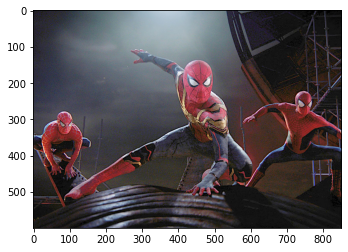

In [1073]:

for i in range(w - newWidth):
    spidey_adjusted, m = resize(spidey_adjusted,m)
plt.imshow(spidey_adjusted)

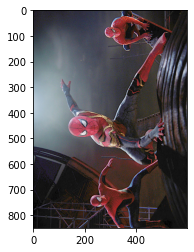

In [1076]:
#york_adjusted = cv2.rotate(york_adjusted, cv2.ROTATE_90_CLOCKWISE)
spidey_adjusted = cv2.transpose(spidey_adjusted)
plt.imshow(spidey_adjusted)

(850, 600, 3)
torch.Size([3, 850, 600])
torch.Size([1, 3, 850, 600])
(850, 599, 3)
torch.Size([3, 850, 599])
torch.Size([1, 3, 850, 599])
(850, 598, 3)
torch.Size([3, 850, 598])
torch.Size([1, 3, 850, 598])
(850, 597, 3)
torch.Size([3, 850, 597])
torch.Size([1, 3, 850, 597])
(850, 596, 3)
torch.Size([3, 850, 596])
torch.Size([1, 3, 850, 596])
(850, 595, 3)
torch.Size([3, 850, 595])
torch.Size([1, 3, 850, 595])
(850, 594, 3)
torch.Size([3, 850, 594])
torch.Size([1, 3, 850, 594])
(850, 593, 3)
torch.Size([3, 850, 593])
torch.Size([1, 3, 850, 593])
(850, 592, 3)
torch.Size([3, 850, 592])
torch.Size([1, 3, 850, 592])
(850, 591, 3)
torch.Size([3, 850, 591])
torch.Size([1, 3, 850, 591])
(850, 590, 3)
torch.Size([3, 850, 590])
torch.Size([1, 3, 850, 590])
(850, 589, 3)
torch.Size([3, 850, 589])
torch.Size([1, 3, 850, 589])
(850, 588, 3)
torch.Size([3, 850, 588])
torch.Size([1, 3, 850, 588])
(850, 587, 3)
torch.Size([3, 850, 587])
torch.Size([1, 3, 850, 587])
(850, 586, 3)
torch.Size([3, 850, 

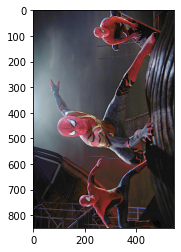

In [1077]:
for i in range(h - newHeight):
    spidey_adjusted, m = resize(spidey_adjusted, m)
plt.imshow(spidey_adjusted)

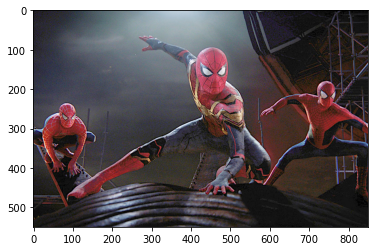

In [1078]:
spidey_adjusted = cv2.transpose(spidey_adjusted)
plt.imshow(spidey_adjusted)